In [3]:
allCSVNames = ['Danny Brown Lyrics.csv', 'Interpol Lyrics.csv', 'Charli XCX Lyrics.csv', 'The Strokes Lyrics.csv', 'Mac Demarco Lyrics.csv', 'Radiohead Lyrics.csv', 'Jack Johnson Lyrics.csv', 'Sufjan Stevens Lyrics.csv', 'Lorde Lyrics.csv', 'The Decemberists Lyrics.csv', 'The National Lyrics.csv', 'Cage The Elephant Lyrics.csv', 'Neutral Milk Hotel Album Lyrics.csv', 'Mac Miller Lyrics.csv', 'Lana Del Rae Lyrics.csv', 'Silver Jews Lyrics.csv', 'Kacey Musgraves Lyrics.csv', 'Haim Lyrics.csv', 'Pavement Lyrics.csv', 'Lake Street Dive Lyrics.csv', 'The 1975 Lyrics.csv', 'Vampire Weekend Lyrics.csv', 'The Lumineers Lyrics.csv', 'Car Seat Headrest Lyrics.csv', 'Alex G Lyrics.csv', 'Carly Rae Jepson Lyrics.csv', 'Alvvays Lyrics.csv', 'Kendrick Lamar Lyrics.csv', 'Brockhampton Lyrics.csv', 'Chastity Belt Lyrics.csv', 'Big Theif Lyrics.csv', 'Adrianne Lenker Lyrics.csv', 'Frank Ocean Lyrics.csv', 'The Smiths Lyrics.csv', 'Death Grips Lyrics.csv', '100 Gecs Lyrics.csv', 'Anderson .Paak Lyrics.csv', 'Vampire Weekend Lyrics.csv', 'New Order Lyrics.csv']

In [85]:
import pandas as pd
import lyricsgenius
import os.path
import csv
import time
import json
import re
from datetime import datetime
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import re
import os
import sys
import time
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

myToken = 'ofa5nyyzhjeCAcPcbdxQCkuKjicWLDGyHUERrXMhT0qjeUGDDfJkubmmxCIayhcn'

def getArtistLyricsDF(artistName, accessToken): 
    genius = lyricsgenius.Genius(accessToken, remove_section_headers=True, skip_non_songs=True)

    artistSongs = genius.search_artist(artistName)
    
    filePath = artistName + "AllSongs.json"
    artistSongs.save_lyrics(filePath, 'json', True)

    with open(filePath) as f:
        data = json.load(f)
    
    #songDictionary = dict()

    columns = ['Artist', 'Album', 'Release Date', 'Lyrics']

    df = pd.DataFrame(columns=columns)

    for index in range(artistSongs.num_songs):
        songName = data['songs'][index]['title']
        if data['songs'][index]['album'] == None or data['songs'][index]['release_date_components'] == None or data['songs'][index]['release_date_components']['year'] == None or data['songs'][index]['release_date_components']['month'] == None or data['songs'][index]['release_date_components']['day'] == None:
            continue
        album = data['songs'][index]['album']['name']
        releaseDate = data['songs'][index]['release_date_components']#['year']

        #Clean the Lyrics
        lyrics = data['songs'][index]['lyrics']
        lyricsNoFirstLine = '\n'.join(lyrics.split('\n')[1:])
        lyricsEmbedRemoved = lyricsNoFirstLine[:-5]
        lyricsNoNums = re.sub(r'\d+', '', lyricsEmbedRemoved)
        if(lyricsNoNums[-19:] == "You might also like"):
            lyricsNoNums = lyricsNoNums[:-19]
        cleanedLyrics = re.sub(r'[^\w\s\'](?=[a-zA-Z])', '', lyricsNoNums)

        df.loc[songName] = [artistName, album, releaseDate, cleanedLyrics]

        #songDictionary[data['songs'][index]['title']] = cleanedLyrics

    
    #df = pd.DataFrame.from_dict(songDictionary, orient='index', columns=['Lyrics'])

    return df


def dateDict2TimeDateObj(dateDict):
    if isinstance(dateDict, dict):
        y = dateDict
    else:
        y = ast.literal_eval(dateDict)
    x = datetime(y['year'], y['month'], y['day'])
    return x


def getLyricsByAlbums(lyricsDF):
    albumLyrics = dict()
    albums = lyricsDF["Album"].unique()
    years = []
    for album in albums:
        albumRows = lyricsDF[lyricsDF['Album'] == album]

        albumYear = albumRows['Release Date Object'].iloc[0]
        years.append(albumYear)
        
        albumRows = albumRows.dropna()
        strings_list = albumRows['Lyrics'].tolist()
        result_string = ' '.join(strings_list)  #passing a float?

        albumLyrics[album] = result_string

    albumLyricsDF = pd.DataFrame.from_dict(albumLyrics, orient="Index", columns=["lyrics"])
    albumLyricsDF["Release Date"] = years
    albumLyricsDF = albumLyricsDF.sort_values("Release Date")
    return albumLyricsDF


# Download the punkt and stopwords from nltk
nltk.download('stopwords')

# Get the stop words and punkt from nltk
stop_words = set(stopwords.words('english'))

nltk.download('punkt')

nltk.download('vader_lexicon')

# Load the sentiment analysis pipeline
sentiment_analyzer = SentimentIntensityAnalyzer()

def getSentimentScore(lyrics):
    splitLyrics = lyrics.split()
    filteredWords1 = [w for w in splitLyrics if not w.lower() in stop_words and w.isalpha()]
    filteredWords2 = ' '.join(filteredWords1)
    return sentiment_analyzer.polarity_scores(filteredWords2)

def plotAlbumSentiment(lyricsByAlbum, graphName):
    plt.plot(lyricsByAlbum.index, lyricsByAlbum['Sentiment'].apply(lambda x: x['neg']), label='Negative Sentiment', marker='o')

    plt.plot(lyricsByAlbum.index, lyricsByAlbum['Sentiment'].apply(lambda x: x['pos']), label='Positive Sentiment', marker='o')

    plt.xlabel('Album')
    plt.ylabel('Sentiment Score')
    plt.title(graphName)
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.show()

def getLyricsAndPlotSentiment(token, artistName):
    lyrics = getArtistLyricsDF(artistName, token)
    lyrics.to_csv(artistName + " Album Lyrics.csv")
    lyrics["Release Date Object"] = lyrics["Release Date"].apply(dateDict2TimeDateObj)
    lyricsByAlbum = getLyricsByAlbums(lyrics)
    lyricsByAlbum["Sentiment"] = lyricsByAlbum["lyrics"].apply(getSentimentScore)
    plotAlbumSentiment(lyricsByAlbum, "Sentiment of " + artistName + " Albums")

def getLyricsAndPlotSentimentFromCSV(artistName, CSVFileName, listOfAlbumNames = None):
    lyrics = pd.read_csv(CSVFileName)
    lyrics["Release Date Object"] = lyrics["Release Date"].apply(dateDict2TimeDateObj)
    lyricsByAlbum = getLyricsByAlbums(lyrics)

    if listOfAlbumNames != None:
        lyricsByAlbum = lyricsByAlbum.loc[listOfAlbumNames]

    lyricsByAlbum["Sentiment"] = lyricsByAlbum["lyrics"].apply(getSentimentScore)
    plotAlbumSentiment(lyricsByAlbum, "Sentiment of " + artistName + " Albums")


def getPolarityScore(NNPDict):
    negative = NNPDict["neg"]
    neutrel = NNPDict["neu"]
    positive = NNPDict["pos"]

    if positive + negative + neutrel == 0:
        return 0
    
    return (positive - negative) / (positive + negative + neutrel)



def getPolarityScoresPerSongFromCSV(CSVFileName):
    lyrics = pd.read_csv(CSVFileName, index_col = 0)
    lyrics["Release Date Object"] = lyrics["Release Date"].apply(dateDict2TimeDateObj)
    
    lyrics.dropna(inplace=True)

    lyrics['Word_Count'] = lyrics['Lyrics'].str.split().str.len()  # Count number of words in each row
    lyrics = lyrics[lyrics['Word_Count'] >= 5]  # Keep only rows where word count is 5 or more
    lyrics = lyrics.drop(columns=['Word_Count'])
    
    lyrics["Sentiment"] = lyrics["Lyrics"].apply(getSentimentScore)

    lyrics["Polarity Score"] = lyrics["Sentiment"].apply(getPolarityScore)
    return lyrics



def GetSTDOfArtistPolarity(csvName):
    df = getPolarityScoresPerSongFromCSV(csvName)
    return df["Polarity Score"].std()

def getAverageNegOrPos(csvName, negOrPos = False):
    df = getPolarityScoresPerSongFromCSV(csvName)
    sentList = df["Sentiment"].to_list()
    if negOrPos:
        x = "pos"
    else:
        x = "neg"

    values = [d[x] for d in sentList]
    average = sum(values) / len(values)
    return average

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gwruth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gwruth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gwruth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [87]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_over_time(csv, artist_name):
    df = getPolarityScoresPerSongFromCSV(csv)
    df.sort_values(by="Release Date Object")
    
    positive_sentiments = []
    negative_sentiments = []

    for index, row in df.iterrows():
        sentiment = row['Sentiment']
        positive_sentiments.append(sentiment['pos'])
        negative_sentiments.append(sentiment['neg'])

    # Plot the sentiment over time
    plt.figure(figsize=(10, 6))
    plt.plot(positive_sentiments, label='Positive Sentiment', color='blue')
    plt.plot(negative_sentiments, label='Negative Sentiment', color='red')
    plt.xlabel('Release Date')
    plt.ylabel('Sentiment Score')
    plt.title(f'Sentiment Of {artist_name} Lyrics Over Time')
    plt.legend()

    # Annotate the graph with first and last song names and release dates
    first_song_name = df.index[0]
    last_song_name = df.index[-1]
    first_release_date = df['Release Date Object'].min().strftime("%m/%d/%Y")  # Assuming your index contains release dates
    last_release_date = df['Release Date Object'].max().strftime("%m/%d/%Y")

    plt.xticks([0, len(df) - 1], [f'{first_song_name}\n{first_release_date}', f'{last_song_name}\n{last_release_date}'])

    plt.ylim(0.0, 0.8)
    plt.tight_layout()
    plt.savefig(f'{artist_name}_Sentiment_Graph.png')
    plt.close()

In [83]:
gec  = getPolarityScoresPerSongFromCSV("Lumineers Lyrics.csv")
gec.sort_values(by="Release Date Object")

,Artist,Album,Release Date,Lyrics,Release Date Object,Sentiment,Polarity Score
Don’t Wanna Go,The Lumineers,The Lumineers EP,"{'year': 2009, 'month': 12, 'day': 15}","Just wake up, I shouted\nThere's some blood, a...",2009-12-15,"{'neg': 0.172, 'neu': 0.626, 'pos': 0.203, 'co...",0.030969
Gun Song,The Lumineers,The Lumineers EP,"{'year': 2009, 'month': 12, 'day': 19}","I don't own a single gun\nBut if I did, you'd ...",2009-12-19,"{'neg': 0.207, 'neu': 0.569, 'pos': 0.225, 'co...",0.017982
Darlene,The Lumineers,The Lumineers EP,"{'year': 2009, 'month': 12, 'day': 19}",I see you\nStanding there\nIn your favorite dr...,2009-12-19,"{'neg': 0.115, 'neu': 0.73, 'pos': 0.154, 'com...",0.039039
Submarines,The Lumineers,The Lumineers EP,"{'year': 2009, 'month': 12, 'day': 19}",I believe submarines\nUnderneath deep blue sea...,2009-12-19,"{'neg': 0.199, 'neu': 0.674, 'pos': 0.127, 'co...",-0.072000
Scotland,The Lumineers,The Lumineers EP,"{'year': 2009, 'month': 12, 'day': 19}",They all need something to hold on to\nThey al...,2009-12-19,"{'neg': 0.127, 'neu': 0.736, 'pos': 0.137, 'co...",0.010000
...,...,...,...,...,...,...,...
​where we are (acoustic),The Lumineers,brightside (acoustic) - EP,"{'year': 2022, 'month': 3, 'day': 16}",Where we are Where we are)\nI don't know where...,2022-03-16,"{'neg': 0.101, 'neu': 0.556, 'pos': 0.344, 'co...",0.242757
​just like heaven,The Lumineers,brightside (acoustic) - EP,"{'year': 2022, 'month': 4, 'day': 27}",Show me how you do that trick\nThat one that m...,2022-04-27,"{'neg': 0.219, 'neu': 0.466, 'pos': 0.315, 'co...",0.096000
​a little sound,The Lumineers,brightside (acoustic) - EP,"{'year': 2022, 'month': 5, 'day': 4}","Let all the air out\nI'm not afraid, I'm on wi...",2022-05-04,"{'neg': 0.285, 'neu': 0.574, 'pos': 0.141, 'co...",-0.144000
A.m. radio (acoustic),The Lumineers,brightside (acoustic) - EP,"{'year': 2022, 'month': 5, 'day': 13}","Standin' on the corner, I could listen to the ...",2022-05-13,"{'neg': 0.109, 'neu': 0.707, 'pos': 0.184, 'co...",0.075000


In [51]:
for i in allCSVNames:
    tempname = ' '.join(i.split()[:-1])
    plot_sentiment_over_time(i, tempname)
    

In [89]:
import os
allCSVNames = ['Danny Brown Lyrics.csv', 'Interpol Lyrics.csv', 'Charli XCX Lyrics.csv', 'The Strokes Lyrics.csv', 'Mac Demarco Lyrics.csv', 'Radiohead Lyrics.csv', 'Jack Johnson Lyrics.csv', 'Sufjan Stevens Lyrics.csv', 'Lorde Lyrics.csv', 'The Decemberists Lyrics.csv', 'The National Lyrics.csv', 'Cage The Elephant Lyrics.csv', 'Neutral Milk Hotel Album Lyrics.csv', 'Mac Miller Lyrics.csv', 'Lana Del Rae Lyrics.csv', 'Silver Jews Lyrics.csv', 'Kacey Musgraves Lyrics.csv', 'Haim Lyrics.csv', 'Pavement Lyrics.csv', 'Lake Street Dive Lyrics.csv', 'The 1975 Lyrics.csv', 'Vampire Weekend Lyrics.csv', 'The Lumineers Lyrics.csv', 'Car Seat Headrest Lyrics.csv', 'Alex G Lyrics.csv', 'Carly Rae Jepson Lyrics.csv', 'Alvvays Lyrics.csv', 'Kendrick Lamar Lyrics.csv', 'Brockhampton Lyrics.csv', 'Chastity Belt Lyrics.csv', 'Big Theif Lyrics.csv', 'Adrianne Lenker Lyrics.csv', 'Frank Ocean Lyrics.csv', 'The Smiths Lyrics.csv', 'Death Grips Lyrics.csv', '100 Gecs Lyrics.csv', 'Anderson .Paak Lyrics.csv', 'Vampire Weekend Lyrics.csv', 'New Order Lyrics.csv']

csvsDF = pd.DataFrame({"CSV Name": [], "Artist Name": [], "STD of Lyric Sentiment": []})

csvsDF["CSV Name"] = allCSVNames
csvsDF["Artist Name"] = csvsDF["CSV Name"].apply(lambda x: " ".join(x.split()[:-1]))
csvsDF["STD of Lyric Sentiment"] = csvsDF["CSV Name"].apply(GetSTDOfArtistPolarity)
csvsDF


,CSV Name,Artist Name,STD of Lyric Sentiment
0,Danny Brown Lyrics.csv,Danny Brown,0.117797
1,Interpol Lyrics.csv,Interpol,0.181432
2,Charli XCX Lyrics.csv,Charli XCX,0.222973
3,The Strokes Lyrics.csv,The Strokes,0.162439
4,Mac Demarco Lyrics.csv,Mac Demarco,0.245627
5,Radiohead Lyrics.csv,Radiohead,0.244919
6,Jack Johnson Lyrics.csv,Jack Johnson,0.167773
7,Sufjan Stevens Lyrics.csv,Sufjan Stevens,0.223586
8,Lorde Lyrics.csv,Lorde,0.139236
9,The Decemberists Lyrics.csv,The Decemberists,0.198859


In [91]:
csvsDF.to_csv("CSV Name, Arist, STD 2.0.csv")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


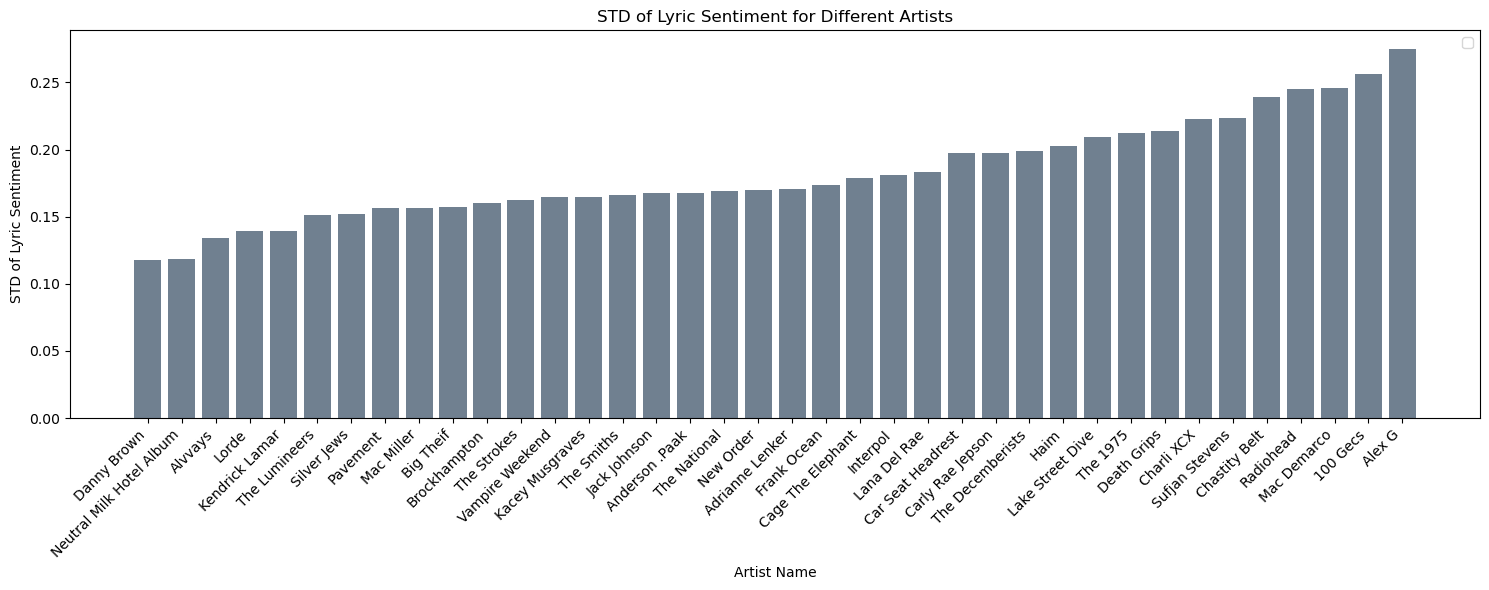

In [90]:

csvsDF.sort_values(by = "STD of Lyric Sentiment", inplace=True)
csvsDF.dropna(inplace=True)
# Plotting
plt.figure(figsize=(15, 6))

# Plotting the bar chart
plt.bar(csvsDF["Artist Name"], csvsDF["STD of Lyric Sentiment"], color='slategray')


# Adding labels and title
plt.xlabel("Artist Name")
plt.ylabel("STD of Lyric Sentiment")
plt.title("STD of Lyric Sentiment for Different Artists")

# Adding legend
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.savefig("Sentiment STD of Different Artists 2.0.png")

In [93]:
df69 = pd.read_csv("CSV Name, Arist, STD 2.0.csv", index_col=0)
df69

,CSV Name,Artist Name,STD of Lyric Sentiment
0,Danny Brown Lyrics.csv,Danny Brown,0.117797
12,Neutral Milk Hotel Album Lyrics.csv,Neutral Milk Hotel Album,0.118727
26,Alvvays Lyrics.csv,Alvvays,0.134291
8,Lorde Lyrics.csv,Lorde,0.139236
27,Kendrick Lamar Lyrics.csv,Kendrick Lamar,0.139290
22,The Lumineers Lyrics.csv,The Lumineers,0.151192
15,Silver Jews Lyrics.csv,Silver Jews,0.152179
18,Pavement Lyrics.csv,Pavement,0.156205
13,Mac Miller Lyrics.csv,Mac Miller,0.156574
30,Big Theif Lyrics.csv,Big Theif,0.156939


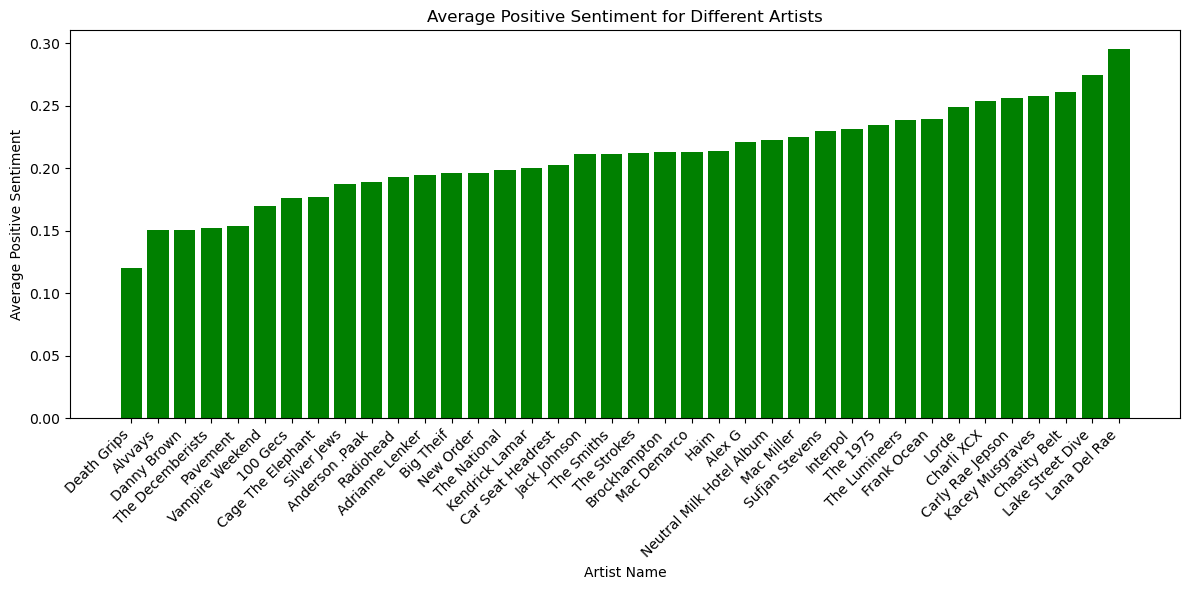

In [95]:
df69["Average Positive Sentiment"] = df69["CSV Name"].apply(getAverageNegOrPos)
df69.sort_values(by = "Average Positive Sentiment", inplace=True)
plt.figure(figsize=(12, 6))

# Plotting the bar chart
plt.bar(df69["Artist Name"], df69["Average Positive Sentiment"], color='green')

# Adding labels and title
plt.xlabel("Artist Name")
plt.ylabel("Average Positive Sentiment")
plt.title("Average Positive Sentiment for Different Artists")

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha = "right")

# Display the plot
plt.tight_layout()
plt.savefig("Average Positive Sentiment 2.0.png")

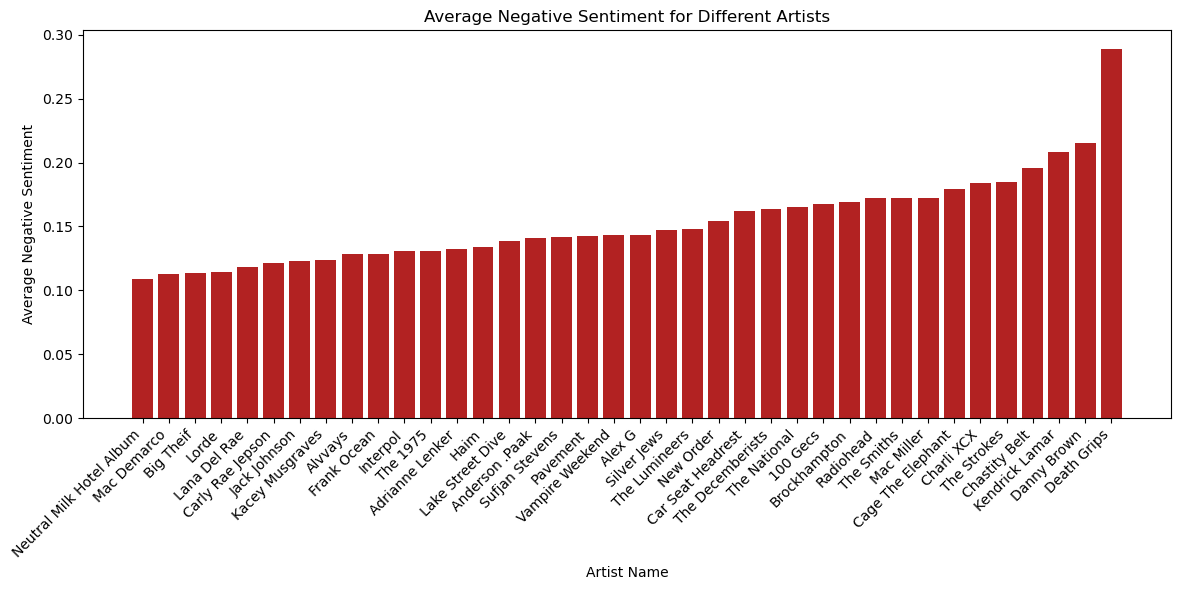

In [99]:
df69["Average Negative Sentiment"] = df69["CSV Name"].apply(getAverageNegOrPos)
df69.sort_values(by = "Average Negative Sentiment", inplace=True)
plt.figure(figsize=(12, 6))

# Plotting the bar chart
plt.bar(df69["Artist Name"], df69["Average Negative Sentiment"], color='firebrick')

# Adding labels and title
plt.xlabel("Artist Name")
plt.ylabel("Average Negative Sentiment")
plt.title("Average Negative Sentiment for Different Artists")

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha = "right")

# Display the plot
plt.tight_layout()
plt.savefig("Average Negative Sentiment 2.0.png")